In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [1]:
%cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/home/ryan/Documents/csci430/Wild-Life/assets


In [3]:
!pip install roboflow

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="czLTKaDZdC3AkImehJDr")
project = rf.workspace("rybeats-live-com").project("wild-life-po")
dataset = project.version(14).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to wild-life-po-14 in yolov5pytorch:: 100%|██████████| 604/604 [00:00<00:00, 6203.60it/s]


In [ ]:
!pip install -qr requirements.txt

In [ ]:
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

: 

In [5]:
%cat {dataset.location}/data.yaml

UsageError: Line magic function `%cat` not found.


In [6]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat models/hub/yolov5m6.yaml

In [7]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
%%writetemplate models/custom_yolov5s6.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [19,27,  44,40,  38,94]  # P3/8
  - [96,68,  86,152,  180,137]  # P4/16
  - [140,301,  303,264,  238,542]  # P5/32
  - [436,615,  739,380,  925,792]  # P6/64

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [768, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [768]],
   [-1, 1, Conv, [1024, 3, 2]],  # 9-P6/64
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 11
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [768, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P5
   [-1, 3, C3, [768, False]],  # 15

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 19

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 23 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 20], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 26 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 16], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [768, False]],  # 29 (P5/32-large)

   [-1, 1, Conv, [768, 3, 2]],
   [[-1, 12], 1, Concat, [1]],  # cat head P6
   [-1, 3, C3, [1024, False]],  # 32 (P6/64-xlarge)

   [[23, 26, 29, 32], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5, P6)
  ]


In [ ]:
!wget https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5m6.pt -O models/yolov5m6.pt

In [ ]:
!python train.py --img 460 --batch 35 --epochs 100 --data wild-life-po-11/data.yaml --cfg models/custom_yolov5s6.yaml --weights 'models/yolov5s6.pt' --name yolov5s6_results  --cache

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

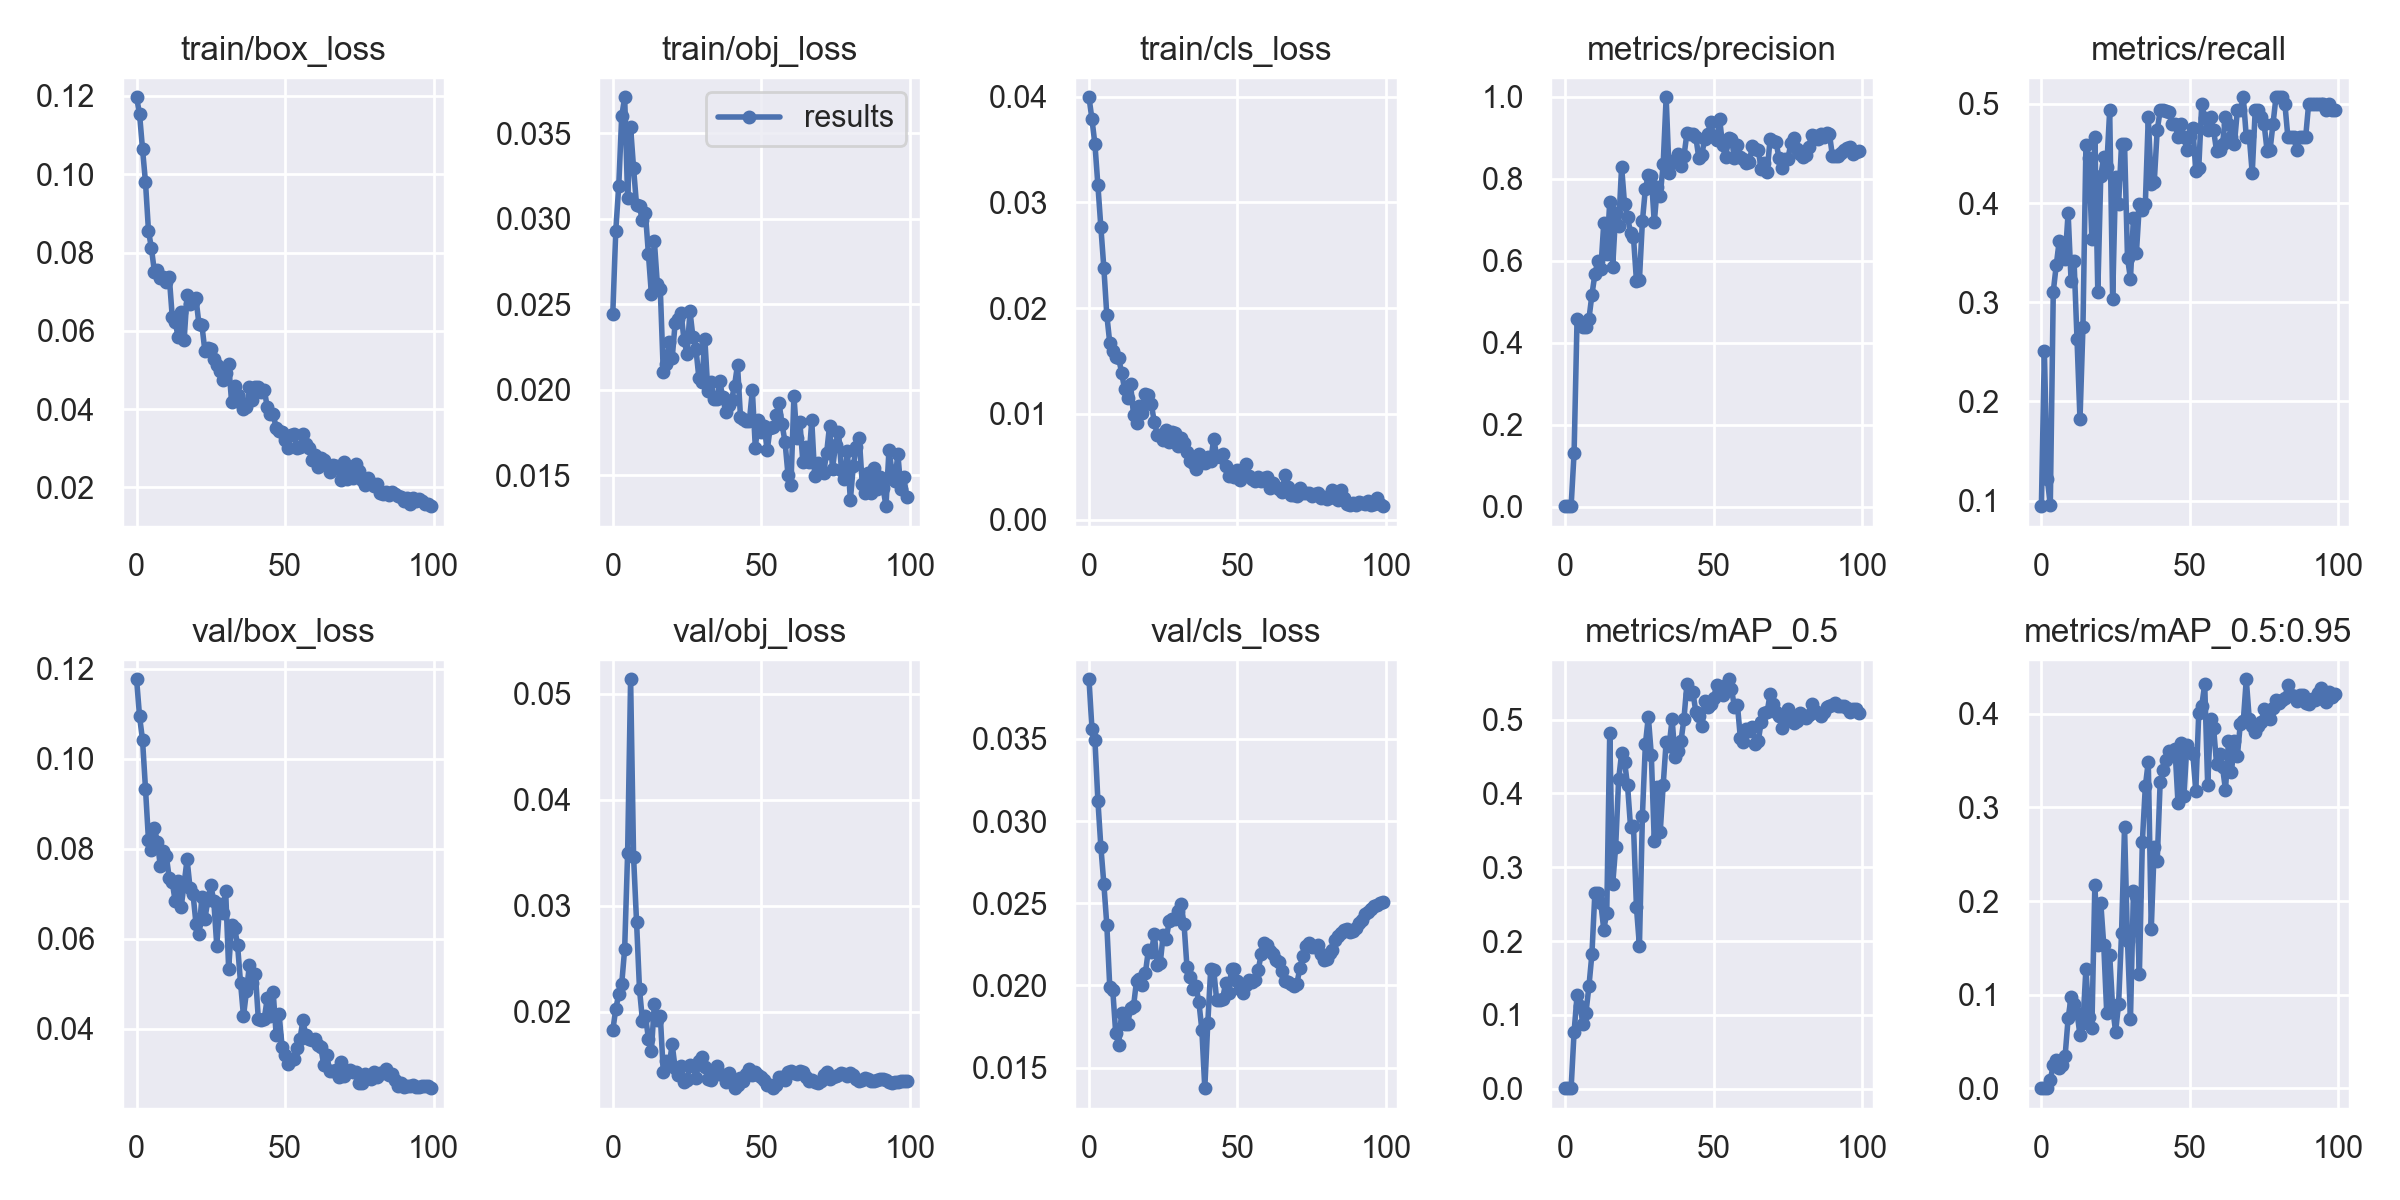

In [11]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='./runs/train/yolov5s6_results2/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


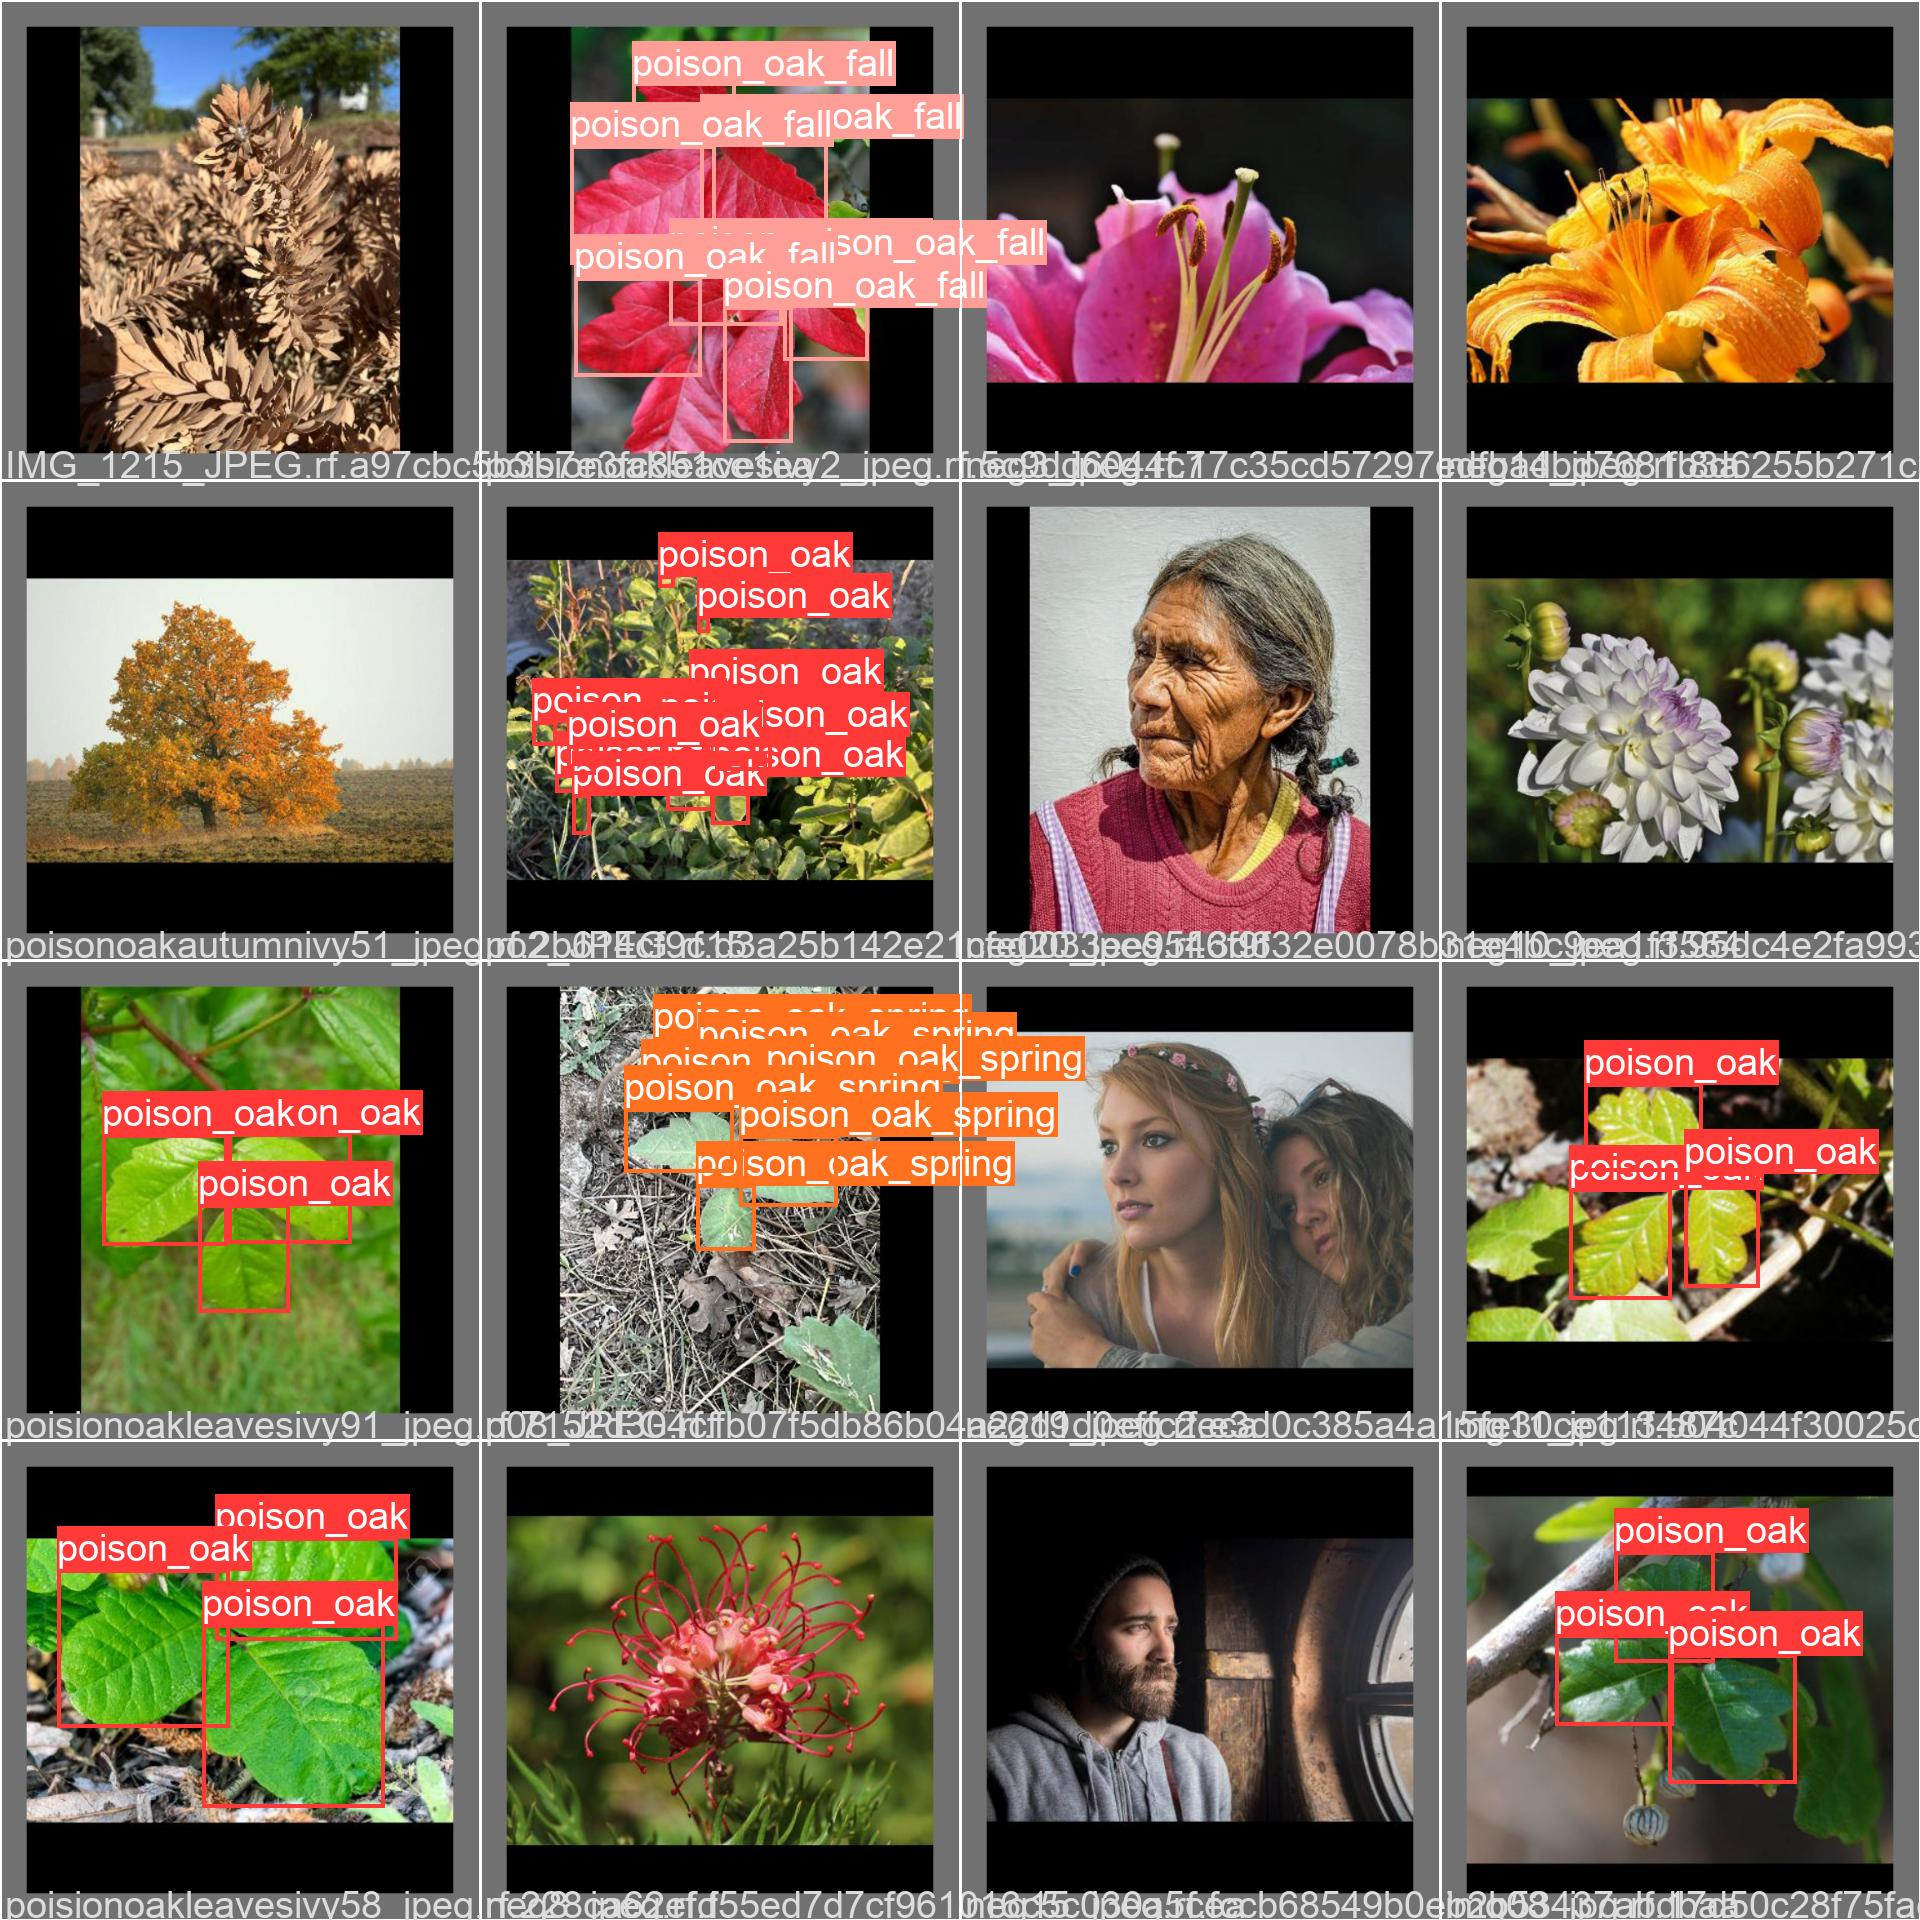

In [12]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/yolov5s6_results2/val_batch0_labels.jpg', width=900)

In [ ]:
!python export.py --include onnx pb --weights 'runs/train/yolov5s6_results2/weights/best.pt'